In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm_notebook

from argparse import Namespace
import os
import collections
from collections import Counter

import string

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
##### 'TRAIN' a new model or 'LOAD' an existing model 
get_model = 'TRAIN'

# @@@@@ 0. Settings

In [3]:
args = Namespace(
    # Training or loading
    get_model   = get_model,
    
    # Data and Path information
    input_path  = os.getcwd(),
    output_path = os.getcwd()+'/OUTPUT/',
    
    # Training hyperparameters
    learning_rate   = 0.001,
    batch_size      = 64,
    hidden_dim      = 300,
    device          = 'cpu',
    num_epochs      = 100,
    early_stopping_criteria = 5
)

# @@@@@ 1. Data Preparation
## The data preparation part is to perform a text-to-vectorized-minibatch pipeline: converting text inputs to vectorized minibatches.
- ### Step 1: Creating a Vocabulary - mapping each token (characters in the context of surnames) in the surname data to a numerical version of itself.
- ### Step 2: Vectorization - going from a text dataset to a vector. The Vectorizer turns different surnames to vectors of integers with the same length.
- ### Step 3: Group the vectorized data points into batches.

## 1.1 - Read Data
### **Train partition**: a dataset to derive the model parameters
### **Valid partition**: a dataset for selecting among hyperparameters and making modeling decisions
### **Test partition**: a dataset for final evaluation and reporting

In [4]:
df_all = pd.read_csv('surnames_with_splits.csv')
df_all.sample(5)

,nationality,nationality_index,split,surname
8403,Russian,13,train,Zhekulin
8371,Russian,13,train,Shahno
7182,Italian,17,test,Gabrielli
8291,Russian,13,train,Renkas
9186,Russian,13,train,Grigoriev


In [5]:
Crosstab = pd.crosstab(df_all['nationality'], df_all['split'])
Crosstab['total'] = Crosstab.sum(axis=1)
Crosstab.loc['Total'] = Crosstab.sum(axis=0)
Crosstab

split,test,train,val,total
nationality,,,,
Arabic,241,1122,240,1603
Chinese,33,154,33,220
Czech,63,289,62,414
Dutch,36,165,35,236
English,447,2080,445,2972
French,35,160,34,229
German,87,403,86,576
Greek,24,109,23,156
Irish,28,128,27,183


## 1.2 - The Vocabulary class
### [A walkthrough of codes](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Surname_Nationality/class_Vocabulary.ipynb)
### - Creating a mapping between the tokens and integers, in terms of dictionaries. To make this mapping reversible, create two dictionaries, one is from-token-to-index, one is from-index-to-token. Then encapsulate this mapping (bijection) into a Vocabulary class.
### - By using the UNK token, we can handle tokens at test time that were never seen in training.
### - Restricting infrequent tokens from the Vocabularies with a pre-specified parameter cut_off. This is essential in limiting the memory used by the Vocabulary class. 
### - Expected behaviors:
#### (1) add_token(): to add new tokens to the Vocabulary
#### (2) lookup_token(): to retrieve the index for a token
#### (3) lookup_index(): to retrieve the token corresponding to a specific index.
### - The Vocabulary objects will be used in the Vectorization step (discussed next). 

In [6]:
class Vocabulary(object):
    """Class to process text and extract vocabulary for mapping"""
    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        """
        Args:
            token_to_idx (dict): a pre-existing map of tokens to indices
            add_unk (bool): a flag that indicates whether to add the UNK token
            unk_token (str): the UNK token to add into the Vocabulary
        """
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx
        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk   = add_unk
        self._unk_token = unk_token      
        self.unk_index  = -999
        ### the unk_token, i.e, "<UNK>" is the first added token if add_unk=True
        ### self.unk_index is changed from -999 to 0
        if add_unk:
            self.unk_index = self.add_token(unk_token) 

    def add_token(self, token):
        """Update mapping dicts based on the token.

        Args:
            token (str): the item to add into the Vocabulary
        Returns:
            index (int): the integer corresponding to the token
        """
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
   
    def lookup_token(self, token):
        """Retrieve the index associated with the token 
          or the UNK index if token isn't present.
        
        Args:
            token (str): the token to look up 
        Returns:
            index (int): the index corresponding to the token
        Notes:
            `unk_index` needs to be >=0 (having been added into the Vocabulary) 
              for the UNK functionality 
        """
        if self.unk_index >= 0:
            ### .get(): return self.unk_index if the key "token" does not exist. 
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]
    
    def lookup_index(self, index):
        """Return the token associated with the index
        
        Args: 
            index (int): the index to look up
        Returns:
            token (str): the token corresponding to the index
        Raises:
            KeyError: if the index is not in the Vocabulary
        """
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]
    
    def __len__(self):
        return len(self._token_to_idx)
    

## 1.3 - Vectorization
### [A walkthrough of codes](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Surname_Nationality/class_Vectorizer_collapsed_one_hots.ipynb)
### - The class method **from_dataframe()** is used to instantiate a SurnameVectorizer object from a dataframe.
### - The SurnameVectorizer encapsulates the nationality vocabulary (nationality_vocab) and the surname vocabulary (surname_vocab).
### - The surname_vocab will be used as the reference for one-hot representation. 
### - The class method **vectorize()** is the core functionality of the Vectorizer. It takes as an argument a string representing a surname and returns a vectorized representation (a vector) of the surname. The length of the vector is equal to the number of elements in the surname vocabulary, surname_vocab. The vectorized representation of surnames with different lengths should have the same length. 
### - Limitations of the one-hot method: (1) sparseness, n_unique_tokens in a surname << n_unique_tokens in a vocabulary; (2) discarding the order of the characters' appearance.

In [7]:
class SurnameVectorizer(object):
    """ The Vectorizer which coordinates the Vocabularies and puts them to use"""
    def __init__(self, surname_vocab, nationality_vocab):
        """
        Args:
            surname_vocab (Vocabulary): maps characters to integers
            nationality_vocab (Vocabulary): maps nationalities to integers
        """
        self.surname_vocab = surname_vocab
        self.nationality_vocab = nationality_vocab
         
    @classmethod
    def from_dataframe(cls, surname_df):
        """Instantiate the vectorizer from the dataset dataframe
        
        Args:
            surname_df (pandas.DataFrame): the surnames dataset
        Returns:
            an instance of the SurnameVectorizer
        """
        surname_vocab     = Vocabulary(add_unk=True, unk_token="@")
        nationality_vocab = Vocabulary(add_unk=False)
        
        ########## Add tokens to surname_vocab and nationality_vocab
        for index, row in surname_df.iterrows():
            # Add tokens(characters) to surname_vocab
            for letter in row.surname:
                surname_vocab.add_token(letter)
            # Add tokens(words) to nationality_vocab
            nationality_vocab.add_token(row.nationality)

        return cls(surname_vocab, nationality_vocab)

    ### This is the key functionality of the Vectorizer.
    ### It takes as an argument a string representing a surname,
    ### and returns a vectorized representation of the surname.
    def vectorize(self, surname):
        """
        Create a collapsed one-hot representation vector for the surname
        Limitations of the one-hot method:
        1 - Sparseness, n_unique_characters in a surname << n_unique_characters in a vocabulary
        2 - Discarding the order of the words' appearance
        
        Args:
            surname (str): the surname 
        Returns:
            one_hot (np.ndarray): the collapsed one-hot encoding 
        """
        ### Create an array where each element corresponds to each character in the vocabulary
        ### Run lookup_token() for each character in the surname sequentially, return an index
        ### Assign the corresponding element in the array to 1.
        vocab   = self.surname_vocab
        one_hot = np.zeros(len(vocab), dtype=np.float32)
        for token in surname:
            one_hot[self.surname_vocab.lookup_token(token)] = 1
        return one_hot

## 1.4 - Batches
### [A walkthrough of codes](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Surname_Nationality/batch_generator.ipynb)

### - Group the vectorized data points into batches. 
### - The grouping is conducted throught the built in class **[DataLoader](https://pytorch.org/docs/stable/data.html)** in PyTorch. 
### - The class SurnameDataset inherits from the [**Dataset**](https://pytorch.org/vision/0.16/datasets.html) class. Instances of the derived class **SurnameDataset** can then be used with data loading tools like **DataLoader()** for efficient batch loading during model training.
### - The methods \_\_len\_\_(), and \_\_getitem\_\_() are defined in class **SurnameDataset** - these magic functions are expected by the **DataLoader()**. An object equipped with \_\_len\_\_() can be passed to the len() Python build-in function. For objects equipped with \_\_getitem\_\_() we can use the standard subscript for indexing tuples and lists to access individual items. 
### - The **DataLoader()** function utilizes the return results of the \_\_getitem\_\_() method in the dataset to construct batches of data. In each iteration, **DataLoader()** calls the \_\_getitem\_\_() method of the dataset to retrieve a sample, and then combines these samples into a batch. 
### - In **DataLoader()**, the \_\_getitem\_\_() method uses an index generated by the **Sampler** object. The **Sampler** is responsible for determining the indices of samples in each batch. This index may be generated sequentially or randomly, depending on the setting of the shuffle parameter.
### - Define a batch generator function that wraps the DataLoader and switch the data between the CPU and the GPU.

In [8]:
class SurnameDataset(Dataset):
    def __init__(self,surname_df,vectorizer):
        self.surname_df  = surname_df
        self._vectorizer = vectorizer
        
        self.train_df    = self.surname_df[self.surname_df.split=='train']
        self.train_size  = len(self.train_df)

        self.val_df      = self.surname_df[self.surname_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df     = self.surname_df[self.surname_df.split=='test']
        self.test_size   = len(self.test_df)
        
        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val'  : (self.val_df, self.validation_size),
                             'test' : (self.test_df, self.test_size)}
        self.set_split('train')
        
        # Class weights - Assign a weight to each class that inversely proportional to its frequency.
        class_counts = surname_df.nationality.value_counts().to_dict()
        def sort_key(item):
            return self._vectorizer.nationality_vocab.lookup_token(item[0])
        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(frequencies, dtype=torch.float32)
        
    @classmethod
    def load_csv_and_make_vectorizer(cls,surname_csv):
        """Load dataset and make a new vectorizer from scratch
        Args:
            surname_csv (str): location of the dataset
        Returns:
            an instance of SurnameDataset
        """
        surname_df = pd.read_csv(surname_csv)
        ### make vectorizer using training dataset
        train_surname_df = surname_df[surname_df.split=='train']
        new_vectorizer  = SurnameVectorizer.from_dataframe(train_surname_df)
        return cls(surname_df,new_vectorizer)
    
    @classmethod
    def load_df_and_make_vectorizer(cls,surname_df):
        """Load dataset and make a new vectorizer from scratch
        Args:
            surname_df: dataset
        Returns:
            an instance of SurnameDataset
        """
        ### make vectorizer using training dataset
        train_surname_df = surname_df[surname_df.split=='train']
        new_vectorizer  = SurnameVectorizer.from_dataframe(train_surname_df)
        return cls(surname_df,new_vectorizer)
    
    def set_split(self, split="train"):
        """ selects the splits in the dataset using a column in the dataframe 
        Args:
            split (str): one of "train", "val", or "test"
        """
        self._target_split = split
        ### when split = 'train', _target_df means the training set
        self._target_df, self._target_size = self._lookup_dict[split]
        
    def __len__(self):
        ### _target_size is defined in set_split() 
        return self._target_size        
        
    def __getitem__(self, index):
        """the primary entry point method for PyTorch datasets
        
        Args:
            index (int): the index to the data point 
        Returns:
            a dictionary holding the data point's features (x_data) and label (y_target)
        """
        
        row = self._target_df.iloc[index]

        surname_vector = \
            self._vectorizer.vectorize(row.surname)

        nationality_index = \
            self._vectorizer.nationality_vocab.lookup_token(row.nationality)

        return {'x_data': surname_vector,
                'y_target': nationality_index}

    def get_vectorizer(self):
        """ returns the vectorizer """
        return self._vectorizer
    
    def get_num_batches(self, batch_size):
        """Given a batch size, return the number of batches in the dataset
        Args:
            batch_size (int)
        Returns:
            number of batches in the dataset
        """
        return len(self) // batch_size  

### Generator Function

In [9]:
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device='cpu'):
    """
    A generator function which wraps the PyTorch DataLoader. It will 
      ensure each tensor is on the write device location.
    """
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

# @@@@@ 2. Model / Optimizer / Loss
## 2.1 - The model (Perceptron) and activate Function (Sigmoid)
### - The **SurnameClassifier** inherits from PyTorch’s **Module** and creates a Multi-layer Perceptron (MLP) classifier. The application of this classifier in a toy data is discussed [in this study](https://github.com/houzhj/Machine_Learning/blob/main/ipynb/Perceptron_ToyData/perceptron_mlp_main.ipynb). 
### - In PyTorch, the **nn.Module** class implements the **\_\_call\_\_** method, enabling model instances to be invoked like functions. Calling an instance from nn.Module with a set of arguments ends up calling a method named forward with the same argument. The forward function executes the forward computation, while **\_\_call\_\_** does other important chores before and after calling forward. In general, the correct way to call the module as a function is to use **Classifier(input)**, rather than **Classifier.forward(input)**, although they will produce the same outputs (silient errors, since there are steps not called properly if just using **forward(...)** directly).
### - The **forward()** method allows for the sigmoid function (working as the nonlinear activation function) to be optionally applied. Here the default is do not apply the sigmoid function. 
### - A structural regularization approach called dropout ([nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)) is applied. Dropout probabilistically drops connections between units belonging to two adjacent layers during training (dropout is applied only during training and not during evaluation). 

In [10]:
class SurnameClassifier(nn.Module):
    """  2-layer Multilayer Perceptron """
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob):
        """
        Args:
            input_dim (int): the size of the input vectors
            hidden_dim (int): the output size of the first Linear layer
            output_dim (int): the output size of the second Linear layer
        """
        super(SurnameClassifier, self).__init__()
        self.fc1     = nn.Linear(input_dim, hidden_dim)
        self.fc2     = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x_in, apply_softmax=False):
        """The forward pass of the classifier
        
        Args:
            x_in (torch.Tensor): an input data tensor. 
                x_in.shape should be (batch, input_dim)
            dropout_p (float): if dropout_p==1: do not apply dropout; 
                               if 0<dropout_p<1, apply F.dropout with p=dropout_p
            apply_softmax (bool): a flag for the softmax activation
                should be false if used with the Cross Entropy losses
        Returns:
            the resulting tensor. tensor.shape should be (batch, output_dim)
        """
        intermediate_vector = F.relu(self.fc1(x_in))
        intermediate_vector = self.dropout(intermediate_vector)
        prediction_vector   = self.fc2(intermediate_vector)

        if apply_softmax:
            prediction_vector = F.softmax(prediction_vector, dim=1)

        return prediction_vector

### Define the model 
### - Data: df_all
### - Training hyperparameters (batch_size, device): defined in args

In [11]:
dataset    = SurnameDataset.load_df_and_make_vectorizer(df_all)

dataloader = DataLoader(dataset=dataset,
                        batch_size=args.batch_size,
                        shuffle=True,
                        drop_last=True)

vectorizer = dataset.get_vectorizer()

classifier = SurnameClassifier(input_dim    = len(vectorizer.surname_vocab),
                               hidden_dim   = args.hidden_dim,
                               output_dim   = len(vectorizer.nationality_vocab),
                               dropout_prob = 0.5)

In [12]:
classifier

SurnameClassifier(
  (fc1): Linear(in_features=77, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=18, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

## 2.2 - The loss function (Binary Cross-Entropy)
### - The loss - "how far off" the model predictions are from the target.
### - The gradient of the loss function - a signal for “how much” the parameters should change (according to "how much" each parameter contributed to the loss function).
### - As mentioned, the loss function should be appropriate for the activation function.

In [13]:
loss_weighted_func   = nn.CrossEntropyLoss(dataset.class_weights)
loss_unweighted_func = nn.CrossEntropyLoss()

## 2.3 - The optimizer and scheduler
### The initialized state of the classifier
### Using [torch.nn.Module.parameters](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.parameters)
#### These are the tensors that the optimizer will get. After calling **model.backward()** the parameters are populated with their grad, and the optimizer then updates their values accordingly during the **optimizer.step()** call.
#### The requires_grad = True argument is telling PyTorch to track the entire family tree of tensors resulting from operations on *parameters*.

In [14]:
list(classifier.parameters())

[Parameter containing:
 tensor([[ 0.0382, -0.0871,  0.0631,  ...,  0.0753,  0.0700,  0.0025],
         [-0.0573, -0.0576, -0.0230,  ..., -0.0844,  0.0661, -0.0235],
         [ 0.0567,  0.0745, -0.0407,  ...,  0.0223,  0.0153,  0.0962],
         ...,
         [-0.0798, -0.0198, -0.0240,  ..., -0.0850, -0.1039,  0.0973],
         [ 0.0114, -0.0149,  0.0125,  ...,  0.0783,  0.0612, -0.0159],
         [-0.1119,  0.0134, -0.0943,  ..., -0.0209,  0.0949,  0.0380]],
        requires_grad=True),
 Parameter containing:
 tensor([ 0.0790, -0.0018,  0.0499,  0.0004, -0.0060, -0.0795, -0.0740,  0.0366,
         -0.0656,  0.0547,  0.0431,  0.0479,  0.1044, -0.1090,  0.0463, -0.0502,
         -0.0400, -0.0738,  0.0811,  0.0498, -0.0723, -0.0522, -0.0242, -0.0009,
         -0.0117,  0.0193, -0.0808,  0.1103, -0.0108,  0.0327, -0.0130, -0.0111,
         -0.0177,  0.0462, -0.0655, -0.0877, -0.0251,  0.0471, -0.0670, -0.0638,
         -0.0961, -0.0684,  0.0803,  0.0048,  0.0774, -0.0917, -0.0098, -0.0729

### Define the [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) optimizer 
#### - the learning rate is set adaptively
#### - it is not sensitive to the scaling of the parameters

In [15]:
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)

### Apply a scheduler for adjusting learning rate
### - [torch.optim.lr_scheduler](https://pytorch.org/docs/stable/optim.html) provides several methods to adjust the learning rate based on the number of epochs.
### - [torch.optim.lr_scheduler.ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau) allows dynamic learning rate reducing based on some validation measurements.
### - This scheduler reads a metrics quantity and if no improvement is seen for a ‘patience’ number of epochs, the learning rate is reduced.
### - Parameters:
1. **mode(str)**: In "min" mode, lr will be reduced when the quantity monitored has stopped decreasing; in "max" mode it will be reduced when the quantity monitored has stopped increasing. Default: 0.1.
2. **factor(float)**: Factor by which the learning rate will be reduced. new_lr = lr * factor. Default: 0.1.
3. **patience (int)**: Number of epochs with no improvement after which learning rate will be reduced. For example, if patience = 2, then we will ignore the first 2 epochs with no improvement, and will only decrease the LR after the 3rd epoch if the loss still hasn’t improved then. Default: 10.
4. **threshold (float)** – Threshold for measuring the new optimum, to only focus on significant changes. Default: 1e-4.

### - A **scheduler.step(val_loss)** method is called at the end of each epoch to execute the update of the learning rate. The parameters “val_loss” represents the loss (or other monitoring metric) computed for the model on the validation set. This loss value is typically used by the scheduler to assess the model's performance on the validation set and update the learning rate accordingly.
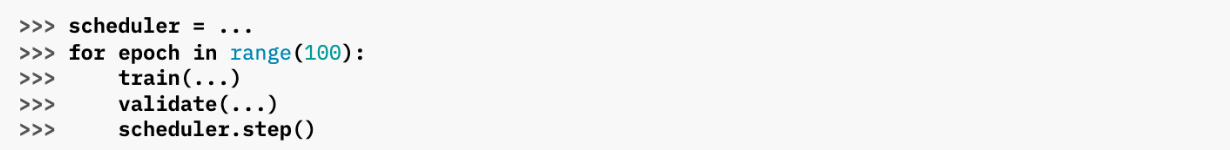

In [16]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

# @@@@@ 3. Training Routine
## 3.1 - Helper function: tracking the training state

In [17]:
def init_train_state(args, save_model_name):
    train_state_dict = {'stop_early'    : False,
                        'early_stopping_step'     : 0,
                        'early_stopping_best_val' : 1e8,
                        'learning_rate' : args.learning_rate,
                        'epoch_index'   : 0,
                        'train_loss'    : [],
                        'train_acc'     : [],
                        'val_loss'      : [],
                        'val_acc'       : [],
                        'test_loss'     : -1,
                        'test_acc'      : -1,
                        'model_filename': save_model_name
                       }
    return train_state_dict

def update_train_state(args, model, train_state):
    """
    Handle the training state updates.
     - Early Stopping: Prevent overfitting.
     - Model Checkpoint: Model is saved if the model is better
    
    Args:
        args:  arguments
        model: model to train
        train_state: a dictionary representing the training state values
    
    Returns:
        a new train_state
    """

    # Save the first model
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss increased (not a better model)
        if loss_t >= train_state['early_stopping_best_val']:
            # Update early_stopping_step
            train_state['early_stopping_step'] += 1
        # If loss decreased
        else:
            # Save the best model and update the early_stopping_best_val
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])
                train_state['early_stopping_best_val'] = loss_t

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        # In the main training loop, if train_state['stop_early']: break
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

## 3.2 - Helper function: compute accurary rate

In [18]:
def compute_accuracy(y_pred, y_target, device):
    y_target = y_target.to(device)

    ##### tensor.max(dim=1): the results include two output tensors (max, max_indices)
    _, y_pred_indices = y_pred.to(device).max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [19]:
##### An example
one_batch = next(iter(dataloader))
classifier(one_batch['x_data']).max(dim=1)

torch.return_types.max(
values=tensor([0.1099, 0.1676, 0.1614, 0.1390, 0.1954, 0.1786, 0.0918, 0.1855, 0.2656,
        0.2303, 0.1918, 0.1628, 0.1016, 0.2286, 0.2298, 0.2727, 0.2017, 0.1177,
        0.1825, 0.1836, 0.2929, 0.1991, 0.1790, 0.1678, 0.1631, 0.1946, 0.2828,
        0.1073, 0.2914, 0.1469, 0.1676, 0.2652, 0.1456, 0.1300, 0.2318, 0.2163,
        0.2129, 0.1073, 0.1512, 0.2185, 0.1506, 0.1355, 0.2704, 0.1864, 0.2747,
        0.2653, 0.1607, 0.1320, 0.1622, 0.2264, 0.2055, 0.2529, 0.2504, 0.1728,
        0.2126, 0.1688, 0.2748, 0.1139, 0.2368, 0.1370, 0.1631, 0.1647, 0.2023,
        0.2204], grad_fn=<MaxBackward0>),
indices=tensor([ 5, 10,  0,  2,  2,  4,  0, 17,  2,  7, 12, 12,  2, 12, 15, 12,  4, 12,
        12,  1, 12,  0,  0, 13,  3, 15, 16,  2,  2,  1, 16,  5,  1,  4, 16, 14,
         4, 15,  2, 15, 11,  2,  2, 12, 10, 12,  2,  4,  2,  0,  1,  5,  0, 10,
        12,  0, 12,  2,  2,  5, 15, 12, 12,  2]))

In [20]:
classifier(one_batch['x_data']).max(dim=1)

torch.return_types.max(
values=tensor([0.2228, 0.1903, 0.1405, 0.0868, 0.1985, 0.2633, 0.1154, 0.2044, 0.2346,
        0.1984, 0.2468, 0.1613, 0.1248, 0.2713, 0.0901, 0.0998, 0.3293, 0.0927,
        0.2011, 0.2004, 0.3625, 0.2440, 0.1989, 0.2490, 0.1652, 0.1397, 0.2243,
        0.1334, 0.2493, 0.1976, 0.2367, 0.1774, 0.1353, 0.1041, 0.2269, 0.1980,
        0.1738, 0.2183, 0.1356, 0.1917, 0.1534, 0.1453, 0.1191, 0.2040, 0.3123,
        0.3048, 0.1671, 0.1636, 0.2298, 0.2301, 0.2450, 0.1126, 0.1768, 0.2664,
        0.3464, 0.1782, 0.2819, 0.2066, 0.2999, 0.1897, 0.1983, 0.2484, 0.2129,
        0.2395], grad_fn=<MaxBackward0>),
indices=tensor([ 4, 10,  4, 12, 12,  4,  1, 13, 12, 15,  2,  2,  1,  2, 11,  2,  2, 17,
         6, 12, 12, 14,  2, 12,  2, 10,  2,  0,  2,  2,  2,  2, 10, 10, 16,  2,
         2, 12,  2, 15,  1,  7,  1, 12, 10, 12, 11, 12, 12, 12,  2, 15, 15, 12,
        12, 12, 12,  2, 15,  0,  4, 12,  4, 12]))

In [21]:
outputs = classifier(one_batch['x_data'])
_, pred = outputs.max(dim=1)  
targets = one_batch['y_target']
print('targets:', targets)
print('-'*80)
print('pred:',pred)
print('-'*80)
print('accurary rate:',compute_accuracy(outputs,targets,device='cpu'))

targets: tensor([ 4, 14, 14, 17, 10, 14,  4,  9,  4,  4,  2,  9,  0,  7,  0, 10, 14,  0,
        14,  4, 14,  4,  4, 10,  0,  3, 14,  1,  4, 14, 13, 14, 14, 10, 13,  4,
        14,  0,  4,  9, 14,  0, 10,  4,  4,  4,  4,  6,  4, 14, 13, 14, 16,  0,
         4, 16,  0,  4, 14,  3,  9,  2, 14,  9])
--------------------------------------------------------------------------------
pred: tensor([13,  7, 17, 15, 17, 10,  0, 12, 15, 10, 13,  4,  2,  2,  4, 15, 15,  4,
        14, 16,  2,  2, 15,  4, 12, 12,  0, 15,  2,  9,  2,  2, 15, 12,  2,  2,
        12,  5,  2, 15,  0, 11, 13, 12,  2,  2,  2, 12, 12,  4,  2,  0, 10, 15,
        12, 12, 13, 16, 10,  1,  4,  4, 13, 12])
--------------------------------------------------------------------------------
accurary rate: 1.5625


## 3.3 - Training loop
### - The training loop updates the model parameters so that it improves over time.
### - The training loop is composed of two loops: an inner loop over batches in the dataset, and an outer loop, which repeats the inner loop a number of times.
### - The inner loop (batch), losses are computed for each batch, and the optimizer is used to update the model parameters.

In [22]:
def print_train_state(train_state):
    print('Train Loss:',round(train_state['train_loss'][-1],5))
    print('Train Accuracy:',round(train_state['train_acc'][-1],5))
    print('Valid Loss:',round(train_state['val_loss'][-1],5))
    print('Valid Accuracy:',round(train_state['val_acc'][-1],5))
    print('early_stopping_best_val:',round(train_state['early_stopping_best_val'],5))
    print('early_stopping_step:',train_state['early_stopping_step'])
    print('stop_early:',train_state['stop_early'])

In [23]:
args

Namespace(get_model='TRAIN', input_path='/Users/home/JH/Machine Learning/Surnames', output_path='/Users/home/JH/Machine Learning/Surnames/OUTPUT/', learning_rate=0.001, batch_size=64, hidden_dim=300, device='cpu', num_epochs=100, early_stopping_criteria=5)

In [24]:
def TrainingClassifier(classifier,args,dataset,use_weight,use_dropout):
    
    optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                     mode='min', factor=0.5,
                                                     patience=1)
    
    if use_weight:
        loss_func       = nn.CrossEntropyLoss(dataset.class_weights)
        if use_dropout:
            save_model_name = args.output_path+'/perceptron_weighted_dropout_model.pth'
        else: 
            save_model_name = args.output_path+'/perceptron_weighted_nodropout_model.pth'
    else:
        loss_func       = nn.CrossEntropyLoss()
        if use_dropout:
            save_model_name = args.output_path+'/perceptron_unweighted_dropout_model.pth'
        else: 
            save_model_name = args.output_path+'/perceptron_unweighted_nodropout_model.pth'
        

    if args.get_model == 'TRAIN':
        ##### Get an initialized train_state
        train_state = init_train_state(args,save_model_name)

        for epoch_index in range(args.num_epochs):
            print('-'*60)
            print(f'Epoch {epoch_index}...')
            train_state['epoch_index'] = epoch_index

            ##################################################
            #####     Iterate over training dataset      #####
            ##################################################
            print('Training Iteration...')

            ##### Create a batch_generator using training data
            dataset.set_split('train')
            batch_generator = generate_batches(dataset,
                                               batch_size=args.batch_size,
                                               device=args.device)

            ##### running_loss and running_acc are equivalent to the moving averages of loss and accuracy.
            ##### when the loop ends, a moving average is just an average. 
            ##### In each epoch loop, they are reset to zero before the batch loop.
            running_loss = 0.0
            running_acc  = 0.0

            ##### Indicate that the model is in “training mode” 
            # makes the model parameters mutable 
            # and enables regularization mechanisms like dropout
            classifier.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # the training routine is these 5 steps:
                # --------------------------------------
                ##### STEP 1. zero the gradients
                # Inside each batch iteration, the optimizer’s gradients are first reset
                # Calling backward (step 4 below) will ACCUMULATE gradients, so if the backward()
                # is called earlier, the new gradient is accumulated on top of the one computed 
                # in previous iterations, which leads ao an incorrect value for the gradient.
                # Therefore, use this zero_ method to reset the gradients.
                optimizer.zero_grad()

                ##### STEP 2. compute the output
                y_pred = classifier(x_in=batch_dict['x_data'].float())

                ##### STEP 3. compute the loss
                loss   = loss_func(y_pred, batch_dict['y_target'])
                loss_t = loss.item()
                # update the moving average of loss, batch by batch
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                ##### STEP 4. use loss to produce gradients (gradients are propagated to each parameter)
                # Calling backward() and the gradients at each leaf is ACCUMULATED, not stored.
                # Note that the loss is the loss in train split. There is no valid_loss.backward()
                # because we don't want to train the model on the validation data. 
                loss.backward()

                ##### STEP 5. use optimizer to update parameters
                # the optimizer uses the propagated gradients to perform parameter updates
                # The value of classifier.parameters(), i.e., params is automatically updated in this step. 
                # In specific, the optimizer looks into params.grad and updates params, by substracting 
                # learning_rate * grad from it. 
                optimizer.step()

                ##### Tracking the accuracy
                # compute the accuracy
                acc_t = compute_accuracy(y_pred, batch_dict['y_target'],args.device)
                # update the moving average of acc, batch by batch
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            ##### After this inner loop (training) ends
            # Append the running_loss and running_acc to train_state
            # (the average of loss and acc in all the batches in the current epoch)
            train_state['train_loss'].append(running_loss)
            train_state['train_acc'].append(running_acc)

            ##################################################
            #####     Iterate over validation dataset    #####
            ##################################################
            print('Validation Iteration...')

            ##### Create a batch_generator using validation data
            dataset.set_split('val')    
            batch_generator = generate_batches(dataset, 
                                               batch_size=args.batch_size, 
                                               device=args.device)
            ##### Create new running loss, and running accuracy
            running_loss = 0.0
            running_acc  = 0.0

            ##### Indicate that the model is in “evaluation mode”
            # makes the model parameters immutable 
            # disables dropout
            # disables computation of the loss and propagation of gradients back to the parameters
            classifier.eval()

            for batch_index, batch_dict in enumerate(batch_generator):
                ##### compute the output
                y_pred = classifier(x_in=batch_dict['x_data'].float())

                ##### STEP 3. compute the loss
                loss   = loss_func(y_pred, batch_dict['y_target'])
                loss_t = loss.item()
                running_loss += (loss_t - running_loss) / (batch_index + 1)

                ##### compute the accuracy
                acc_t = compute_accuracy(y_pred, batch_dict['y_target'],args.device)
                running_acc += (acc_t - running_acc) / (batch_index + 1)

            ##### After this inner loop (validation) ends
            # Append the running_loss and running_acc to train_state
            # (the average of loss and acc in all the batches in the current epoch)
            train_state['val_loss'].append(running_loss)
            train_state['val_acc'].append(running_acc)

            ##### Update the status of Early Stopping and Model Checkpoint
            # Input: the current classifier and current train_state (end of the current epoch loop)
            # Update three items in train_state
            # 1."early_stopping_step" +=1 or reset to 0 (comparing val_loss and early_stopping_best_val)
            # 2."early_stopping_best_val" update to the current val_loss if it is the best model
            # 3."stop_early" if early_stopping_step reaches early_stopping_criteria. If True, break all loops below. 
            # Save a new model if the current model has early_stopping_best_val
            train_state = update_train_state(args = args, model = classifier,
                                             train_state = train_state)

            scheduler.step(train_state['val_loss'][-1])
            print('Current lr:', optimizer.param_groups[0]['lr'])

            print_train_state(train_state)

            if train_state['stop_early']:
                break

    elif args.get_model == 'LOAD':
        print('Please load the model.')
        
    

### Model 1 - Use weight, no dropout layer

In [25]:
dataset    = SurnameDataset.load_df_and_make_vectorizer(df_all)
classifier = SurnameClassifier(input_dim  = len(vectorizer.surname_vocab),
                               hidden_dim = args.hidden_dim,
                               output_dim = len(vectorizer.nationality_vocab),
                               dropout_prob = 0)
TrainingClassifier(classifier=classifier,
                   args=args,
                   dataset=dataset,
                   use_weight=True,
                   use_dropout=False)

------------------------------------------------------------
Epoch 0...
Training Iteration...
Validation Iteration...
Current lr: 0.001
Train Loss: 2.72848
Train Accuracy: 26.35417
Valid Loss: 2.50124
Valid Accuracy: 44.1875
early_stopping_best_val: 100000000.0
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 1...
Training Iteration...
Validation Iteration...
Current lr: 0.001
Train Loss: 2.22645
Train Accuracy: 40.36458
Valid Loss: 2.14015
Valid Accuracy: 43.3125
early_stopping_best_val: 2.14015
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 2...
Training Iteration...
Validation Iteration...
Current lr: 0.001
Train Loss: 1.92003
Train Accuracy: 42.17448
Valid Loss: 2.0066
Valid Accuracy: 35.875
early_stopping_best_val: 2.0066
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 3...
Training Iteration...
Validati

### Model 2 - No weight, no dropout layer

In [26]:
dataset    = SurnameDataset.load_df_and_make_vectorizer(df_all)
classifier = SurnameClassifier(input_dim  = len(vectorizer.surname_vocab),
                               hidden_dim = args.hidden_dim,
                               output_dim = len(vectorizer.nationality_vocab),
                               dropout_prob = 0)
TrainingClassifier(classifier=classifier,
                   args=args,
                   dataset=dataset,
                   use_weight=False,
                   use_dropout=False)

------------------------------------------------------------
Epoch 0...
Training Iteration...
Validation Iteration...
Current lr: 0.001
Train Loss: 2.09473
Train Accuracy: 40.85938
Valid Loss: 1.71798
Valid Accuracy: 49.4375
early_stopping_best_val: 100000000.0
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 1...
Training Iteration...
Validation Iteration...
Current lr: 0.001
Train Loss: 1.58473
Train Accuracy: 53.125
Valid Loss: 1.50402
Valid Accuracy: 54.5625
early_stopping_best_val: 1.50402
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 2...
Training Iteration...
Validation Iteration...
Current lr: 0.001
Train Loss: 1.41899
Train Accuracy: 56.70573
Valid Loss: 1.42044
Valid Accuracy: 56.25
early_stopping_best_val: 1.42044
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 3...
Training Iteration...
Validatio

Validation Iteration...
Current lr: 0.000125
Train Loss: 0.80692
Train Accuracy: 74.20573
Valid Loss: 1.08663
Valid Accuracy: 66.375
early_stopping_best_val: 1.08663
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 29...
Training Iteration...
Validation Iteration...
Current lr: 0.000125
Train Loss: 0.80532
Train Accuracy: 74.16667
Valid Loss: 1.09544
Valid Accuracy: 65.9375
early_stopping_best_val: 1.08663
early_stopping_step: 1
stop_early: False
------------------------------------------------------------
Epoch 30...
Training Iteration...
Validation Iteration...
Current lr: 6.25e-05
Train Loss: 0.8037
Train Accuracy: 74.16667
Valid Loss: 1.09784
Valid Accuracy: 66.1875
early_stopping_best_val: 1.08663
early_stopping_step: 2
stop_early: False
------------------------------------------------------------
Epoch 31...
Training Iteration...
Validation Iteration...
Current lr: 6.25e-05
Train Loss: 0.80027
Train Accuracy: 74.36198
Val

### Model 3 - Use weight, use dropout layer (p=0.5)

In [27]:
dataset    = SurnameDataset.load_df_and_make_vectorizer(df_all)
classifier = SurnameClassifier(input_dim  = len(vectorizer.surname_vocab),
                               hidden_dim = args.hidden_dim,
                               output_dim = len(vectorizer.nationality_vocab),
                               dropout_prob = 0.5)
TrainingClassifier(classifier=classifier,
                   args=args,
                   dataset=dataset,
                   use_weight=True,
                   use_dropout=True)

------------------------------------------------------------
Epoch 0...
Training Iteration...
Validation Iteration...
Current lr: 0.001
Train Loss: 2.77622
Train Accuracy: 27.39583
Valid Loss: 2.60813
Valid Accuracy: 41.25
early_stopping_best_val: 100000000.0
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 1...
Training Iteration...
Validation Iteration...
Current lr: 0.001
Train Loss: 2.40875
Train Accuracy: 36.4974
Valid Loss: 2.25426
Valid Accuracy: 41.0
early_stopping_best_val: 2.25426
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 2...
Training Iteration...
Validation Iteration...
Current lr: 0.001
Train Loss: 2.11684
Train Accuracy: 38.71094
Valid Loss: 2.1194
Valid Accuracy: 40.0625
early_stopping_best_val: 2.1194
early_stopping_step: 0
stop_early: False
------------------------------------------------------------
Epoch 3...
Training Iteration...
Validation It

# @@@@@ 4. Evaluation
## 4.1 - Evaluation on Test Data
### A. Weighted Model

In [28]:
classifier_weighted = SurnameClassifier(input_dim  = len(vectorizer.surname_vocab),
                                        hidden_dim = args.hidden_dim,
                                        output_dim = len(vectorizer.nationality_vocab),
                                        dropout_prob = 0)
filename   = args.output_path+'/perceptron_weighted_nodropout_model.pth'
classifier_weighted.load_state_dict(torch.load(filename))
classifier_weighted = classifier_weighted.to(args.device)

loss_func  = nn.CrossEntropyLoss(dataset.class_weights)

##### Create a batch_generator using test data
# The test set should be run as little as possible
# Avoid make a new model decision based on the evaluation on test data
# Otherwise the model might be biased toward the test data, and the test data will 
# become meaningless as an measure of truly held-out data.
dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)

##### Create new running loss, and running accuracy
running_loss = 0.0
running_acc = 0.0

##### Indicate that the model is in “evaluation mode”
classifier_weighted.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier_weighted(batch_dict['x_data'])

    # compute the loss
    loss   = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'],args.device)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

print("Test loss: {:.5f}".format(running_loss))
print("Test Accuracy: {:.5f}".format(running_acc))

Test loss: 1.78539
Test Accuracy: 43.93750


### B. Un-weighted Model

In [29]:
classifier_unweighted = SurnameClassifier(input_dim  = len(vectorizer.surname_vocab),
                                        hidden_dim = args.hidden_dim,
                                        output_dim = len(vectorizer.nationality_vocab),
                                        dropout_prob = 0)
filename   = args.output_path+'/perceptron_unweighted_nodropout_model.pth'
classifier_unweighted.load_state_dict(torch.load(filename))
classifier_unweighted = classifier_unweighted.to(args.device)

loss_func  = nn.CrossEntropyLoss()

##### Create a batch_generator using test data
# The test set should be run as little as possible
# Avoid make a new model decision based on the evaluation on test data
# Otherwise the model might be biased toward the test data, and the test data will 
# become meaningless as an measure of truly held-out data.
dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)

##### Create new running loss, and running accuracy
running_loss = 0.0
running_acc = 0.0

##### Indicate that the model is in “evaluation mode”
classifier_unweighted.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = classifier_unweighted(batch_dict['x_data'])

    # compute the loss
    loss   = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'],args.device)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

print("Test loss: {:.5f}".format(running_loss))
print("Test Accuracy: {:.5f}".format(running_acc))

Test loss: 1.10757
Test Accuracy: 65.93750


## 4.2 Generation a prediction for a given surname

In [30]:
surnames = {
    'Smith': 'English',
    'Yamamoto': 'Japanese',
    'Dubois': 'French',
    'Rossi': 'Italian',
    'Zhang':  'Chinese',
    'Petrov':  'Russian' ,
    'Kowalski': 'Polish',
    'Park': 'Korean'
 }
surnames

{'Smith': 'English',
 'Yamamoto': 'Japanese',
 'Dubois': 'French',
 'Rossi': 'Italian',
 'Zhang': 'Chinese',
 'Petrov': 'Russian',
 'Kowalski': 'Polish',
 'Park': 'Korean'}

In [31]:
def predict_surname(surname,
                    classifier,
                    device, 
                    vectorizer,
                    top_k):
    """Predict the nationality of a surname
    
    Args:
        surname (str): the text of the surname
        classifier (SurnameClassifier): the trained model
        device: device
        vectorizer (SurnameVectorizer): the corresponding vectorizer
        top_k: specify the k in “top-k”
    """
    
    classifier = classifier.to(device)
    vectorized_surname = torch.tensor(vectorizer.vectorize(surname)).view(1, -1)
    output = classifier(vectorized_surname, apply_softmax=True)
    
    probability_value, index = torch.topk(output, k=top_k)
    
    ### Predicted label 
    index = index.detach().numpy()[0]
    
    ### Predicted probability 
    probability_value = probability_value.detach().numpy()[0]
    
    results = []
    for p, i in zip(probability_value, index):
        nationality = vectorizer.nationality_vocab.lookup_index(i)
        results.append({'nationality': nationality, 
                        'probability': p})
    
    return results

In [32]:
surname    = 'Schmidt'
classifier = classifier_unweighted
device     = 'cpu'
vectorizer = dataset.get_vectorizer()
predict_surname(surname,
                classifier,
                device, 
                vectorizer,5)

[{'nationality': 'German', 'probability': 0.52292305},
 {'nationality': 'English', 'probability': 0.2875557},
 {'nationality': 'Czech', 'probability': 0.044871833},
 {'nationality': 'Russian', 'probability': 0.040959775},
 {'nationality': 'Scottish', 'probability': 0.040926404}]

In [33]:
surname    = 'Schmidt'
classifier = classifier_unweighted
device     = 'cpu'
vectorizer = dataset.get_vectorizer()
predict_surname(surname,
                classifier,
                device, 
                vectorizer,1)

[{'nationality': 'German', 'probability': 0.52292305}]

### A. Weighted Model

In [34]:
classifier = classifier_weighted
device     = 'cpu'
vectorizer = dataset.get_vectorizer()
for s,n in surnames.items():
    print('surname:', s)
    print('nationality:', n)
    print('predicted(top k)')
    print(predict_surname(s,classifier,
                          device,vectorizer,5))
    print('-'*60)

surname: Smith
nationality: English
predicted(top k)
[{'nationality': 'Japanese', 'probability': 0.2911704}, {'nationality': 'German', 'probability': 0.26281708}, {'nationality': 'Scottish', 'probability': 0.112027735}, {'nationality': 'Arabic', 'probability': 0.07801036}, {'nationality': 'Dutch', 'probability': 0.060138777}]
------------------------------------------------------------
surname: Yamamoto
nationality: Japanese
predicted(top k)
[{'nationality': 'Japanese', 'probability': 0.8982482}, {'nationality': 'English', 'probability': 0.025691174}, {'nationality': 'Spanish', 'probability': 0.01421031}, {'nationality': 'Russian', 'probability': 0.013383169}, {'nationality': 'Czech', 'probability': 0.012690381}]
------------------------------------------------------------
surname: Dubois
nationality: French
predicted(top k)
[{'nationality': 'Greek', 'probability': 0.5182757}, {'nationality': 'French', 'probability': 0.16895542}, {'nationality': 'Portuguese', 'probability': 0.0983045},

### B. Un-weighted Model

In [35]:
classifier = classifier_unweighted
device     = 'cpu'
vectorizer = dataset.get_vectorizer()
for s,n in surnames.items():
    print('surname:', s)
    print('nationality:', n)
    print('predicted(top k)')
    print(predict_surname(s,classifier,
                          device,vectorizer,5))
    print('-'*60)

surname: Smith
nationality: English
predicted(top k)
[{'nationality': 'Japanese', 'probability': 0.40172392}, {'nationality': 'German', 'probability': 0.25073037}, {'nationality': 'English', 'probability': 0.2133755}, {'nationality': 'Russian', 'probability': 0.06426141}, {'nationality': 'Czech', 'probability': 0.02117653}]
------------------------------------------------------------
surname: Yamamoto
nationality: Japanese
predicted(top k)
[{'nationality': 'Japanese', 'probability': 0.9466237}, {'nationality': 'English', 'probability': 0.043866567}, {'nationality': 'Russian', 'probability': 0.0051435702}, {'nationality': 'Spanish', 'probability': 0.0012612671}, {'nationality': 'Czech', 'probability': 0.0008855156}]
------------------------------------------------------------
surname: Dubois
nationality: French
predicted(top k)
[{'nationality': 'Greek', 'probability': 0.28990543}, {'nationality': 'French', 'probability': 0.22784594}, {'nationality': 'English', 'probability': 0.2171686},